# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql import Window

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, MinMaxScaler, StringIndexer, OneHotEncoder, RFormula
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import sklearn
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project Small") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
data_filepath = 'data/mini_sparkify_event_data.json'

In [5]:
df = spark.read.json(data_filepath)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [8]:
df.count()

286500

In [9]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


### Describe numeric columns

In [10]:
numeric_cols = ['itemInSession','length', 'registration', 'sessionId', 'status', 'ts']

In [11]:
df.describe(numeric_cols).toPandas()

,summary,itemInSession,length,registration,sessionId,status,ts
0,count,286500,228108,278154,286500,286500,286500
1,mean,114.41421291448516,249.1171819778458,1.5353588340844272E12,1041.526554973822,210.05459685863875,1.5409568898104834E12
2,stddev,129.76726201140994,99.23517921058361,3.291321616327586E9,726.7762634630741,31.50507848842214,1.5075439608226302E9
3,min,0,0.78322,1521380675000,1,200,1538352117000
4,max,1321,3024.66567,1543247354000,2474,404,1543799476000


### Describe categorical columns

In [12]:
cat_cols = [col for col in df.columns if col not in numeric_cols]

In [13]:
for column in cat_cols:
    print('Column:' + column)
    print(df.groupBy(column).count().sort('count', ascending=False).toPandas())
    print('===================================================================')

Column:artist
                                                  artist  count
0                                                   None  58392
1                                          Kings Of Leon   1841
2                                               Coldplay   1813
3                                 Florence + The Machine   1236
4                                          Dwight Yoakam   1135
5                                               BjÃÂ¶rk   1133
6                                         The Black Keys   1125
7                                                   Muse   1090
8                                          Justin Bieber   1044
9                                           Jack Johnson   1007
10                                                Eminem    953
11                                             Radiohead    884
12                                       Alliance Ethnik    876
13                                                 Train    854
14                        

  method   count
0    PUT  261064
1    GET   25436
Column:page
                         page   count
0                    NextSong  228108
1                        Home   14457
2                   Thumbs Up   12551
3             Add to Playlist    6526
4                  Add Friend    4277
5                 Roll Advert    3933
6                       Login    3241
7                      Logout    3226
8                 Thumbs Down    2546
9                   Downgrade    2055
10                       Help    1726
11                   Settings    1514
12                      About     924
13                    Upgrade     499
14              Save Settings     310
15                      Error     258
16             Submit Upgrade     159
17           Submit Downgrade      63
18                     Cancel      52
19  Cancellation Confirmation      52
20                   Register      18
21        Submit Registration       5
Column:song
                                                   

     userId  count
0        39   9632
1             8346
2        92   7230
3       140   6880
4    300011   5732
5       124   4825
6    300021   4659
7    300017   4428
8        85   4370
9        42   4257
10   200023   3769
11        6   3761
12       29   3603
13       54   3437
14      100   3214
15        9   3191
16      126   3102
17   300015   3051
18       91   3014
19       98   2891
20       74   2887
21      118   2868
22      136   2567
23       65   2544
24      138   2469
25       88   2465
26       51   2464
27        4   2442
28       97   2404
29       81   2335
..      ...    ...
196  300007    143
197     144    125
198     154    118
199      72    117
200      57    112
201      32    108
202      63    107
203  300024    102
204      84     97
205  100019     89
206  200012     84
207     116     79
208  100003     78
209  200007     76
210  100017     75
211      34     73
212      64     68
213     122     62
214     134     52
215      68     48
216      90 

In [14]:
get_timestamp = sf.udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [15]:
df = df.withColumn("datetime", get_timestamp(df.ts))

In [16]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57')

### EDA Overall Questions

#### - Who are the top-10 Artists overall?

In [17]:
top10_artists = df.filter(df.artist != 'None').groupBy('artist').count().sort('count', ascending=False).toPandas().iloc[:10,:]
top10_artists

,artist,count
0,Kings Of Leon,1841
1,Coldplay,1813
2,Florence + The Machine,1236
3,Dwight Yoakam,1135
4,BjÃÂ¶rk,1133
5,The Black Keys,1125
6,Muse,1090
7,Justin Bieber,1044
8,Jack Johnson,1007
9,Eminem,953


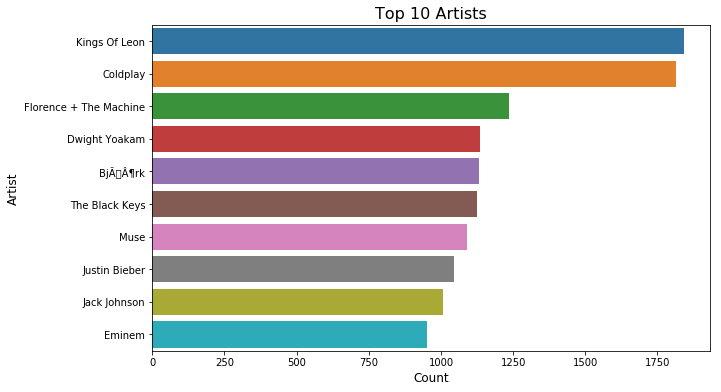

In [18]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="count", y="artist", data=top10_artists)
plt.title('Top 10 Artists',size=16);
plt.xlabel('Count', size=12)
plt.ylabel('Artist', size=12);

In [19]:
f.savefig("./assets/top-10-artists.png", bbox_inches='tight', dpi=600)

#### - Which are the top-10 songs overall?

In [20]:
top10_songs = df.filter(df.song != 'None').groupBy(['song','artist']).count().sort('count', ascending=False) \
                .toPandas().iloc[:10,:] \
                .assign(song = lambda x: x.song if len(x.song) <= 25 else x.song.str[:25] + '...') \
                .assign(song = lambda x: (x.song.str[:20] + '  -  ' + x.artist).str[:40]) \
                .drop('artist',axis=1)
                
top10_songs

,song,count
0,You're The One - Dwight Yoakam,1122
1,Undo - BjÃÂ¶rk,1026
2,Revelry - Kings Of Leon,854
3,Sehr kosmisch - Harmonia,728
4,Horn Concerto No. 4 - Barry Tuckwell/,641
5,Dog Days Are Over (R - Florence + The,574
6,Secrets - OneRepublic,463
7,Use Somebody - Kings Of Leon,459
8,Canada - Five Iron Frenzy,434
9,Invalid - Tub Ring,424


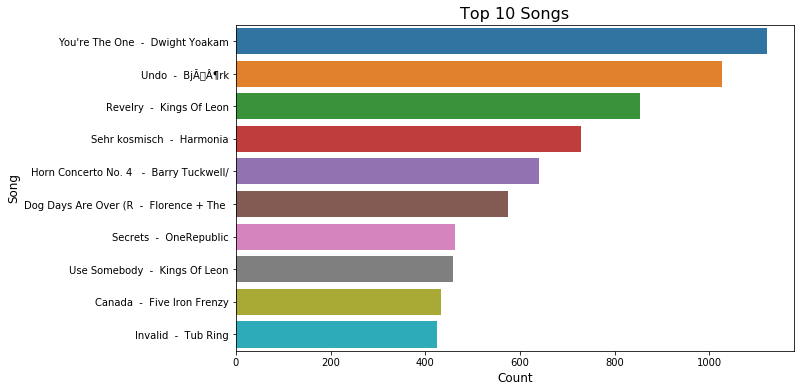

In [21]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="count", y="song", data=top10_songs)
plt.title('Top 10 Songs',size=16)
plt.xlabel('Count', size=12)
plt.ylabel('Song', size=12);

In [22]:
f.savefig("./assets/top-10-songs.png", bbox_inches='tight', dpi=600)

#### - How is the distribution of listening time for paid versus free users?

In [23]:
non_null_listening_time = df.filter(df.length.isNotNull()).select(['level','length']).toPandas()
non_null_listening_time.head(10)

,level,length
0,paid,277.89016
1,free,236.09424
2,paid,282.82730
3,free,262.71302
4,paid,223.60771
5,free,208.29995
6,free,260.46649
7,paid,185.44281
8,paid,134.47791
9,free,229.87710


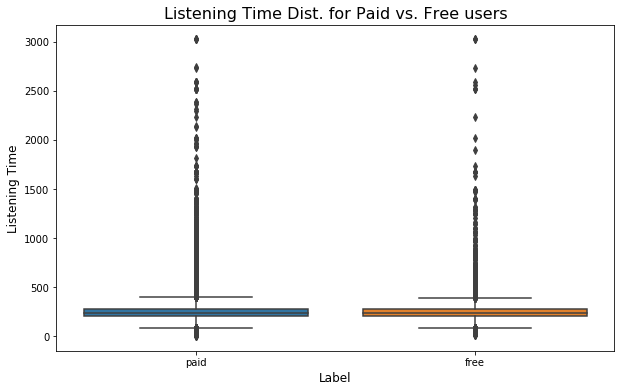

In [24]:
f, axis = plt.subplots(figsize=(10, 6))
sns.boxplot(x="level", y="length", data=non_null_listening_time);
plt.title('Listening Time Dist. for Paid vs. Free users',size=16)
plt.xlabel('Label', size=12)
plt.ylabel('Listening Time', size=12);

In [25]:
f.savefig("./assets/list-time-paid-free-users.png", bbox_inches='tight', dpi=600)

#### - How is the distribution of the average number of songs listened along the hours of the day for paid versus free versus all users?

In [26]:
get_datetime_hour = sf.udf(lambda x: None if x == None else int(x.split(' ')[1][:2]), st.IntegerType())
df = df.withColumn('hour', get_datetime_hour('datetime'))
get_datetime_date = sf.udf(lambda x: None if x == None else x.split(' ')[0])
df = df.withColumn('date', get_datetime_date('datetime'))
songs_per_hour_level = df.filter(df.song != 'None').groupBy(['level','date','hour']).count().groupBy(['level','hour']).agg(sf.avg('count').alias('mean_num_songs')).sort('mean_num_songs', ascending=False).toPandas()
songs_per_hour_level

,level,hour,mean_num_songs
0,paid,16,149.344262
1,paid,17,148.475410
2,paid,18,147.409836
3,paid,19,147.229508
4,paid,15,145.098361
5,paid,20,144.786885
6,paid,21,140.114754
7,paid,22,134.934426
8,paid,14,134.426230
9,paid,23,130.163934


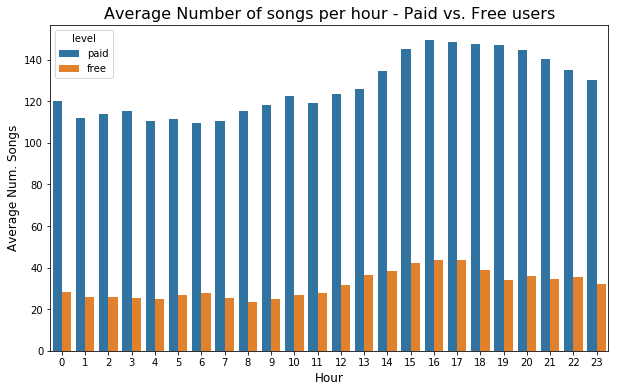

In [27]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="hour", y="mean_num_songs", hue='level', data=songs_per_hour_level);
plt.title('Average Number of songs per hour - Paid vs. Free users',size=16)
plt.xlabel('Hour', size=12)
plt.ylabel('Average Num. Songs', size=12);

In [28]:
f.savefig("./assets/avg-num-songs-per-hour.png", bbox_inches='tight', dpi=600)

#### - How is the distribution of users per region?

In [29]:
get_region = sf.udf(lambda x: None if x == None else x.split(',')[1])
df = df.withColumn('region', get_region('location'))
users_per_region = df.filter(df.region != 'None').groupBy('region').count().sort('count', ascending=False).toPandas()
users_per_region.head(10)

,region,count
0,CA,46771
1,NY-NJ-PA,23684
2,TX,23494
3,MA-NH,13873
4,FL,13190
5,NC,10688
6,NC-SC,7780
7,CO,7493
8,MI,7216
9,NJ,7001


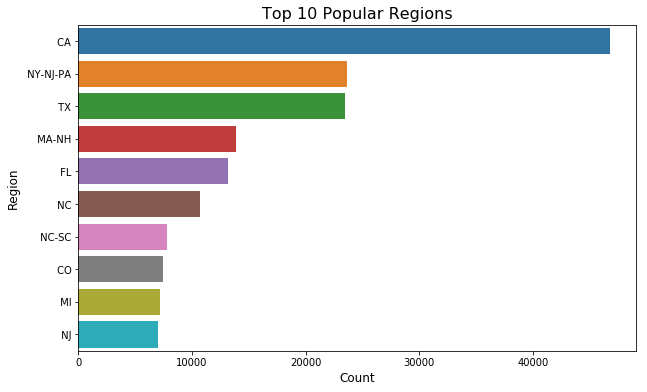

In [30]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="count", y="region", data=users_per_region.head(10));
plt.title('Top 10 Popular Regions',size=16)
plt.xlabel('Count', size=12)
plt.ylabel('Region', size=12);

In [31]:
f.savefig("./assets/activity-per-region.png", bbox_inches='tight', dpi=600)

## Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Create Churn column based on the Cancellation Confirmation event

#### Overview of the Cancellation Confirmation event on the dataset

In [32]:
df.filter(df.page == 'Cancellation Confirmation').take(5)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', datetime='2018-10-07 20:26:30', hour=20, date='2018-10-07', region=' MO-KS'),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32', datetime='2

In [33]:
df.select(["userId", "datetime", "page", "level", "length"]).filter(df.userId == '125').collect()

[Row(userId='125', datetime='2018-10-12 04:05:44', page='NextSong', level='free', length=337.91955),
 Row(userId='125', datetime='2018-10-12 04:11:21', page='NextSong', level='free', length=230.03383),
 Row(userId='125', datetime='2018-10-12 04:15:11', page='NextSong', level='free', length=203.2322),
 Row(userId='125', datetime='2018-10-12 04:18:34', page='NextSong', level='free', length=210.83383),
 Row(userId='125', datetime='2018-10-12 04:22:04', page='NextSong', level='free', length=391.26159),
 Row(userId='125', datetime='2018-10-12 04:28:35', page='NextSong', level='free', length=213.60281),
 Row(userId='125', datetime='2018-10-12 04:32:08', page='NextSong', level='free', length=178.41587),
 Row(userId='125', datetime='2018-10-12 04:35:06', page='NextSong', level='free', length=323.81342),
 Row(userId='125', datetime='2018-10-12 04:35:17', page='Roll Advert', level='free', length=None),
 Row(userId='125', datetime='2018-10-12 04:35:18', page='Cancel', level='free', length=None),


In [34]:
flag_churn_1 = sf.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, st.IntegerType())

In [35]:
df = df.withColumn("churned1", flag_churn_1("page"))

In [36]:
df.select(["userId", "datetime", "page", "level", "length", "churned1"]).filter(df.userId == '125').collect()

[Row(userId='125', datetime='2018-10-12 04:05:44', page='NextSong', level='free', length=337.91955, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:11:21', page='NextSong', level='free', length=230.03383, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:15:11', page='NextSong', level='free', length=203.2322, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:18:34', page='NextSong', level='free', length=210.83383, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:22:04', page='NextSong', level='free', length=391.26159, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:28:35', page='NextSong', level='free', length=213.60281, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:32:08', page='NextSong', level='free', length=178.41587, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:35:06', page='NextSong', level='free', length=323.81342, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:35:17', page='Roll Advert', level='free', length=None,

### Create Churn2 column considering the Submit Downgrade event

#### Overview of the Submit Downgrade event on the dataset

In [37]:
df.filter(df.page == 'Submit Downgrade').take(5)

[Row(artist=None, auth='Logged In', firstName='Kael', gender='M', itemInSession=47, lastName='Baker', length=None, level='paid', location='Kingsport-Bristol-Bristol, TN-VA', method='PUT', page='Submit Downgrade', registration=1533102330000, sessionId=249, song=None, status=307, ts=1538393619000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='131', datetime='2018-10-01 11:33:39', hour=11, date='2018-10-01', region=' TN-VA', churned1=0),
 Row(artist=None, auth='Logged In', firstName='Calvin', gender='M', itemInSession=17, lastName='Marshall', length=None, level='paid', location='Pittsburgh, PA', method='PUT', page='Submit Downgrade', registration=1537120757000, sessionId=313, song=None, status=307, ts=1538516445000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"', userId='38', datetime='2018-10-02 21:40:45', hour

In [38]:
df.select(["userId", "datetime", "page", "level", "length"]).filter(df.userId == '30').collect()

[Row(userId='30', datetime='2018-10-01 00:01:57', page='NextSong', level='paid', length=277.89016),
 Row(userId='30', datetime='2018-10-01 00:06:34', page='NextSong', level='paid', length=282.8273),
 Row(userId='30', datetime='2018-10-01 00:11:16', page='NextSong', level='paid', length=223.60771),
 Row(userId='30', datetime='2018-10-01 00:14:59', page='NextSong', level='paid', length=185.44281),
 Row(userId='30', datetime='2018-10-01 00:15:05', page='Add to Playlist', level='paid', length=None),
 Row(userId='30', datetime='2018-10-01 00:18:04', page='NextSong', level='paid', length=134.47791),
 Row(userId='30', datetime='2018-10-01 00:20:18', page='NextSong', level='paid', length=223.58159),
 Row(userId='30', datetime='2018-10-01 00:24:01', page='NextSong', level='paid', length=246.69995),
 Row(userId='30', datetime='2018-10-01 00:28:07', page='NextSong', level='paid', length=222.22322),
 Row(userId='30', datetime='2018-10-01 00:31:49', page='NextSong', level='paid', length=223.92118),

In [39]:
home_acc_window = Window.partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)

In [40]:
df = df.withColumn('next_level', sf.lead('level').over(
    Window.partitionBy('userId').orderBy('ts')
    )
)

In [41]:
flag_churn_2 = sf.udf(lambda x, y: 1 if (x == "Submit Downgrade" and y == "free") else 0, st.IntegerType())

In [42]:
df = df.withColumn("churned2", flag_churn_2("page","next_level"))

In [43]:
df.select(["userId", "datetime", "page", "level", "length", "next_level", "churned2"]).filter(df.userId == '30').collect()

[Row(userId='30', datetime='2018-10-01 00:01:57', page='NextSong', level='paid', length=277.89016, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:06:34', page='NextSong', level='paid', length=282.8273, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:11:16', page='NextSong', level='paid', length=223.60771, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:14:59', page='NextSong', level='paid', length=185.44281, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:15:05', page='Add to Playlist', level='paid', length=None, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:18:04', page='NextSong', level='paid', length=134.47791, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:20:18', page='NextSong', level='paid', length=223.58159, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:24:01', page='NextSong', level='paid', l

### Create Churn3 column considering both Cancellation Confirmation and Submit Downgrade events

In [44]:
or_between_cols = sf.udf(lambda x, y: 1 if ((x == 1) | (y == 1)) else 0, st.IntegerType())

In [45]:
df = df.withColumn("churned3", or_between_cols("churned1","churned2"))

In [46]:
df.select(["datetime", "page", "level", "next_level", "churned1", "churned2", "churned3"]).filter(df.userId == '30').collect()

[Row(datetime='2018-10-01 00:01:57', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:06:34', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:11:16', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:14:59', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:15:05', page='Add to Playlist', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:18:04', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:20:18', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:24:01', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Churn EDA Questions

#### - How is the distribution of churning/downgrading/cancelling users over the months of the year?

In [47]:
get_datetime_month = sf.udf(lambda x: None if x == None else int(x.split(' ')[0][5:7]), st.IntegerType())
df = df.withColumn('month', get_datetime_month('datetime'))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', hour=12, date='2018-10-08', region=' CT', churned1=0, next_level='free', churned2=0, churned3=0, month=10)

In [48]:
churning_per_month = df.groupBy('month').agg(
                        (sf.sum('churned1')/sf.countDistinct('userId')).alias('cancelled'),
                        (sf.sum('churned2')/sf.countDistinct('userId')).alias('downgraded'),
                        (sf.sum('churned3')/sf.countDistinct('userId')).alias('churned')) \
                        .toPandas() \
                    .melt(id_vars=['month'], 
                          value_vars=['cancelled','downgraded','churned'],
                          var_name='Churn Type',
                          value_name='prop')

churning_per_month

,month,Churn Type,prop
0,12,cancelled,0.000000
1,10,cancelled,0.140187
2,11,cancelled,0.117021
3,12,downgraded,0.000000
4,10,downgraded,0.172897
5,11,downgraded,0.132979
6,12,churned,0.000000
7,10,churned,0.313084
8,11,churned,0.250000


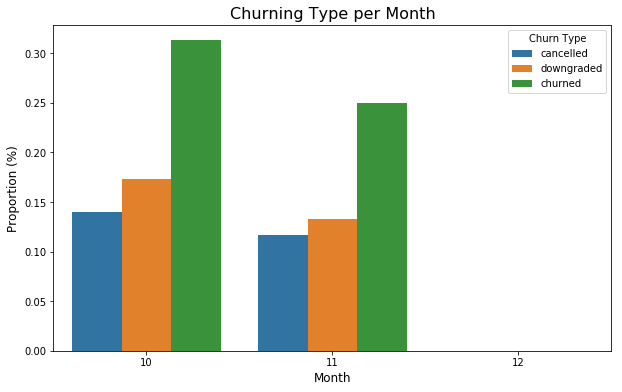

In [49]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="month", y="prop", hue="Churn Type", data=churning_per_month)
plt.title('Churning Type per Month',size=16)
plt.xlabel('Month', size=12)
plt.ylabel('Proportion (%)', size=12)
f.savefig("./assets/churn-type-per-month.png", bbox_inches='tight', dpi=600);

#### - How is the distribution of churning/downgrading/cancelling users per region?

In [50]:
churning_per_region = df.groupBy('region').agg(
                        (sf.sum('churned1')/sf.countDistinct('userId')).alias('cancelled'),
                        (sf.sum('churned2')/sf.countDistinct('userId')).alias('downgraded'),
                        (sf.sum('churned3')/sf.countDistinct('userId')).alias('churned'),
                        (sf.countDistinct('userId').alias('users'))) \
                        .toPandas() \
                    .melt(id_vars=['region'], 
                          value_vars=['cancelled','downgraded','churned','users'],
                          var_name='Churn Type',
                          value_name='prop') \
                    .sort_values(['prop'], ascending=False)

churning_per_region.head(10)

,region,Churn Type,prop
203,CA,users,33.0
206,TX,users,16.0
204,NY-NJ-PA,users,15.0
199,FL,users,14.0
190,AZ,users,7.0
220,CT,users,7.0
231,NC-SC,users,6.0
194,MO-IL,users,6.0
184,IL-IN-WI,users,6.0
235,NC,users,6.0


In [51]:
largest_regions = churning_per_region[churning_per_region['Churn Type'] == 'users'].sort_values('prop', ascending=False)
largest_regions

,region,Churn Type,prop
203,CA,users,33.0
206,TX,users,16.0
204,NY-NJ-PA,users,15.0
199,FL,users,14.0
190,AZ,users,7.0
220,CT,users,7.0
231,NC-SC,users,6.0
194,MO-IL,users,6.0
184,IL-IN-WI,users,6.0
235,NC,users,6.0


In [52]:
filtered_regions = largest_regions[largest_regions['prop'] >=10]
filtered_regions

,region,Churn Type,prop
203,CA,users,33.0
206,TX,users,16.0
204,NY-NJ-PA,users,15.0
199,FL,users,14.0


In [53]:
top_churning_per_region = churning_per_region[(churning_per_region['region'].isin(filtered_regions['region'])) & (churning_per_region['Churn Type'] != 'users')]
top_churning_per_region

,region,Churn Type,prop
145,NY-NJ-PA,churned,0.666667
144,CA,churned,0.666667
140,FL,churned,0.642857
85,CA,downgraded,0.484848
147,TX,churned,0.437500
81,FL,downgraded,0.428571
86,NY-NJ-PA,downgraded,0.333333
27,NY-NJ-PA,cancelled,0.333333
88,TX,downgraded,0.250000
22,FL,cancelled,0.214286


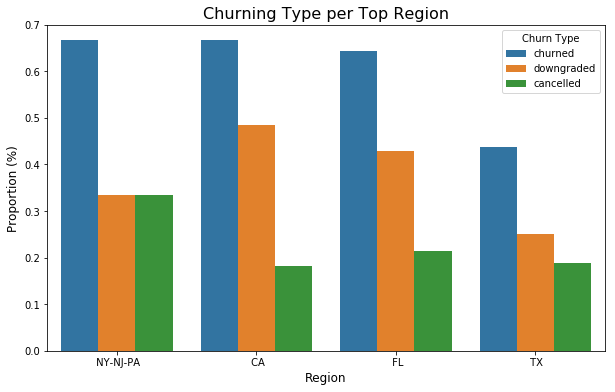

In [54]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="region", y="prop", hue="Churn Type", data=top_churning_per_region);
plt.title('Churning Type per Top Region',size=16)
plt.xlabel('Region', size=12)
plt.ylabel('Proportion (%)', size=12)
f.savefig("./assets/churn-type-per-region.png", bbox_inches='tight', dpi=600);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Build X dataframe

#### Select id, basic features and reference timestamp

In [55]:
X_base_df = df.groupBy(['userId','date']) \
                .agg(sf.first('region').alias('region'),
                     sf.first('gender').alias('gender'))

In [56]:
X_base_df.take(5)

[Row(userId='100', date='2018-10-25', region=' TX', gender='M'),
 Row(userId='100009', date='2018-10-01', region=' CA', gender='M'),
 Row(userId='100009', date='2018-10-05', region=' CA', gender='M'),
 Row(userId='124', date='2018-10-30', region=' NJ', gender='F'),
 Row(userId='131', date='2018-10-20', region=' TN-VA', gender='M')]

In [57]:
X_base_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- gender: string (nullable = true)



#### Add computed feature: Median Listening Time in the previous 1, 3, 7, and 14 days

In [58]:
recent_list_time = df.groupBy(['userId','date']) \
                    .agg(sf.mean('length').alias('mean_list_time')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['mean_list_time']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)
recent_list_time.filter(recent_list_time.userId == '30').toPandas()

,userId,date,mean_list_time,timestamp
0,30,2018-10-01,269.813969,1538352000
1,30,2018-10-06,164.701590,1538784000
2,30,2018-10-07,232.347435,1538870400
3,30,2018-10-08,259.483355,1538956800
4,30,2018-10-10,396.146486,1539129600
5,30,2018-10-11,251.658676,1539216000
6,30,2018-10-15,259.953366,1539561600
7,30,2018-10-16,0.000000,1539648000
8,30,2018-10-20,0.000000,1539993600
9,30,2018-10-23,259.968068,1540252800


In [59]:
recent_list_time.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- mean_list_time: double (nullable = false)
 |-- timestamp: long (nullable = true)



In [60]:
millis_in_a_day = 24*60*60
millis_in_a_day

86400

In [61]:
w_1day_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((millis_in_a_day)-1),0)
w_3days_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((3*millis_in_a_day)-1),0)
w_7days_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((7*millis_in_a_day)-1),0)
w_14days_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((14*millis_in_a_day)-1),0)

In [62]:
recent_list_time = recent_list_time.withColumn('mean_list_time_in_24_hours',sf.mean('mean_list_time').over(w_1day_before)) \
        .withColumn('mean_list_time_in_3_days',sf.mean('mean_list_time').over(w_3days_before)) \
        .withColumn('mean_list_time_in_7_days',sf.mean('mean_list_time').over(w_7days_before)) \
        .withColumn('mean_list_time_in_14_days',sf.mean('mean_list_time').over(w_14days_before))

In [63]:
recent_list_time.filter(df.userId == '30').toPandas()

,userId,date,mean_list_time,timestamp,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days
0,30,2018-10-01,269.813969,1538352000,269.813969,269.813969,269.813969,269.813969
1,30,2018-10-06,164.701590,1538784000,164.701590,164.701590,217.257779,217.257779
2,30,2018-10-07,232.347435,1538870400,232.347435,198.524513,222.287665,222.287665
3,30,2018-10-08,259.483355,1538956800,259.483355,218.844127,218.844127,231.586587
4,30,2018-10-10,396.146486,1539129600,396.146486,327.814920,263.169716,264.498567
5,30,2018-10-11,251.658676,1539216000,251.658676,323.902581,260.867508,262.358585
6,30,2018-10-15,259.953366,1539561600,259.953366,259.953366,302.586176,260.715151
7,30,2018-10-16,0.000000,1539648000,0.000000,129.976683,226.939632,223.470130
8,30,2018-10-20,0.000000,1539993600,0.000000,0.000000,86.651122,199.941331
9,30,2018-10-23,259.968068,1540252800,259.968068,259.968068,129.984034,194.621099


In [64]:
recent_list_time.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- mean_list_time: double (nullable = false)
 |-- timestamp: long (nullable = true)
 |-- mean_list_time_in_24_hours: double (nullable = true)
 |-- mean_list_time_in_3_days: double (nullable = true)
 |-- mean_list_time_in_7_days: double (nullable = true)
 |-- mean_list_time_in_14_days: double (nullable = true)



#### Add computed feature: Accessed Cancel/Downgrade pages within last month/two weeks/3 days/24 hours

##### Mark accesses to cancel and downgrade pages

In [65]:
flag_acc_canc_downg = sf.udf(lambda x: 1 if (x == "Cancel" or x == "Downgrade") else 0, st.IntegerType())

In [66]:
df = df.withColumn("acc_canc_downg", flag_acc_canc_downg("page"))

In [67]:
recent_acc_canc_downg = df.groupBy(['userId','date']) \
                    .agg(sf.sum('acc_canc_downg').alias('acc_canc_downg')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['mean_list_time']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)

In [68]:
recent_acc_canc_downg.filter(recent_acc_canc_downg.acc_canc_downg > 0).toPandas()

,userId,date,acc_canc_downg,timestamp
0,10,2018-10-18,3,1539820800
1,10,2018-11-03,1,1541203200
2,10,2018-11-16,2,1542326400
3,10,2018-11-19,1,1542585600
4,100,2018-10-04,1,1538611200
5,100,2018-10-09,3,1539043200
6,100,2018-10-10,3,1539129600
7,100,2018-10-17,2,1539734400
8,100,2018-10-23,1,1540252800
9,100,2018-10-24,2,1540339200


In [69]:
recent_acc_canc_downg = recent_acc_canc_downg.withColumn('acc_canc_downg_in_24_hours',sf.mean('acc_canc_downg').over(w_1day_before)) \
        .withColumn('acc_canc_downg_in_3_days',sf.mean('acc_canc_downg').over(w_3days_before)) \
        .withColumn('acc_canc_downg_in_7_days',sf.mean('acc_canc_downg').over(w_7days_before)) \
        .withColumn('acc_canc_downg_in_14_days',sf.mean('acc_canc_downg').over(w_14days_before))

In [70]:
recent_acc_canc_downg.filter(df.userId == '100').toPandas()

,userId,date,acc_canc_downg,timestamp,acc_canc_downg_in_24_hours,acc_canc_downg_in_3_days,acc_canc_downg_in_7_days,acc_canc_downg_in_14_days
0,100,2018-10-02,0,1538438400,0.0,0.000000,0.000000,0.000000
1,100,2018-10-03,0,1538524800,0.0,0.000000,0.000000,0.000000
2,100,2018-10-04,1,1538611200,1.0,0.333333,0.333333,0.333333
3,100,2018-10-07,0,1538870400,0.0,0.000000,0.250000,0.250000
4,100,2018-10-09,3,1539043200,3.0,1.500000,1.000000,0.800000
5,100,2018-10-10,3,1539129600,3.0,3.000000,1.750000,1.166667
6,100,2018-10-17,2,1539734400,2.0,2.000000,2.000000,1.800000
7,100,2018-10-19,0,1539907200,0.0,1.000000,1.000000,1.600000
8,100,2018-10-23,1,1540252800,1.0,1.000000,1.000000,1.500000
9,100,2018-10-24,2,1540339200,2.0,1.500000,1.000000,1.250000


#### Add computed feature: Number of accesses to Thumbs Up minus Number of accesses to Thumbs Down page

In [71]:
flag_thumbs_up = sf.udf(lambda x: 1 if (x == "Thumbs Up") else 0, st.IntegerType())

In [72]:
flag_thumbs_down = sf.udf(lambda x: 1 if (x == "Thumbs Down") else 0, st.IntegerType())

In [73]:
df = df.withColumn("acc_thumbs_up", flag_thumbs_up("page")) \
        .withColumn("acc_thumbs_down", flag_thumbs_down("page"))

In [74]:
recent_acc_thumbs_up_down = df.groupBy(['userId','date']) \
                    .agg(sf.sum('acc_thumbs_up').alias('acc_thumbs_up'),
                         sf.sum('acc_thumbs_down').alias('acc_thumbs_down')) \
                    .withColumn('thumbs_up_down', sf.col('acc_thumbs_up') - sf.col('acc_thumbs_down')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['mean_list_time']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)

In [75]:
recent_acc_thumbs_up_down.filter(recent_acc_thumbs_up_down.thumbs_up_down != 0).toPandas()

,userId,date,acc_thumbs_up,acc_thumbs_down,thumbs_up_down,timestamp
0,10,2018-10-08,3,0,3,1538956800
1,10,2018-10-18,17,2,15,1539820800
2,10,2018-10-19,6,2,4,1539907200
3,10,2018-10-29,2,0,2,1540771200
4,10,2018-11-03,5,0,5,1541203200
5,10,2018-11-15,1,0,1,1542240000
6,10,2018-11-19,3,0,3,1542585600
7,100,2018-10-02,9,3,6,1538438400
8,100,2018-10-03,1,0,1,1538524800
9,100,2018-10-04,6,1,5,1538611200


In [76]:
recent_acc_thumbs_up_down = recent_acc_thumbs_up_down \
        .withColumn('thumbs_up_down_in_24_hours',sf.mean('thumbs_up_down').over(w_1day_before)) \
        .withColumn('thumbs_up_down_in_3_days',sf.mean('thumbs_up_down').over(w_3days_before)) \
        .withColumn('thumbs_up_down_in_7_days',sf.mean('thumbs_up_down').over(w_7days_before)) \
        .withColumn('thumbs_up_down_in_14_days',sf.mean('thumbs_up_down').over(w_14days_before))

In [77]:
recent_acc_thumbs_up_down.filter(df.userId == '98').toPandas()

,userId,date,acc_thumbs_up,acc_thumbs_down,thumbs_up_down,timestamp,thumbs_up_down_in_24_hours,thumbs_up_down_in_3_days,thumbs_up_down_in_7_days,thumbs_up_down_in_14_days
0,98,2018-10-01,1,2,-1,1538352000,-1.0,-1.000000,-1.000000,-1.000000
1,98,2018-10-02,1,0,1,1538438400,1.0,0.000000,0.000000,0.000000
2,98,2018-10-04,5,0,5,1538611200,5.0,3.000000,1.666667,1.666667
3,98,2018-10-05,0,0,0,1538697600,0.0,2.500000,1.250000,1.250000
4,98,2018-10-06,9,3,6,1538784000,6.0,3.666667,2.200000,2.200000
5,98,2018-10-08,1,0,1,1538956800,1.0,3.500000,2.600000,2.000000
6,98,2018-10-09,1,0,1,1539043200,1.0,1.000000,2.600000,1.857143
7,98,2018-10-13,1,0,1,1539388800,1.0,1.000000,1.000000,1.750000
8,98,2018-10-16,3,0,3,1539648000,3.0,3.000000,2.000000,2.428571
9,98,2018-10-19,1,0,1,1539907200,1.0,1.000000,1.666667,2.166667


#### Add computed feature: Number of accesses to Login minus Number of accesses to Logout page

In [78]:
flag_login = sf.udf(lambda x: 1 if (x == "Login") else 0, st.IntegerType())

In [79]:
flag_logout = sf.udf(lambda x: 1 if (x == "Logout") else 0, st.IntegerType())

In [80]:
df = df.withColumn("acc_login", flag_login("page")) \
        .withColumn("acc_logout", flag_logout("page"))

In [81]:
recent_acc_login_logout = df.groupBy(['userId','date']) \
                    .agg(sf.sum('acc_login').alias('acc_login'),
                         sf.sum('acc_logout').alias('acc_logout')) \
                    .withColumn('login_logout', sf.col('acc_login') - sf.col('acc_logout')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['mean_list_time']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)

In [82]:
recent_acc_login_logout.filter(recent_acc_login_logout.login_logout != 0).toPandas()

,userId,date,acc_login,acc_logout,login_logout,timestamp
0,,2018-10-01,72,0,72,1538352000
1,,2018-10-02,57,0,57,1538438400
2,,2018-10-03,72,0,72,1538524800
3,,2018-10-04,52,0,52,1538611200
4,,2018-10-05,65,0,65,1538697600
5,,2018-10-06,36,0,36,1538784000
6,,2018-10-07,34,0,34,1538870400
7,,2018-10-08,59,0,59,1538956800
8,,2018-10-09,66,0,66,1539043200
9,,2018-10-10,77,0,77,1539129600


In [83]:
recent_acc_login_logout = recent_acc_login_logout \
        .withColumn('login_logout_in_24_hours',sf.mean('login_logout').over(w_1day_before)) \
        .withColumn('login_logout_in_3_days',sf.mean('login_logout').over(w_3days_before)) \
        .withColumn('login_logout_in_7_days',sf.mean('login_logout').over(w_7days_before)) \
        .withColumn('login_logout_in_14_days',sf.mean('login_logout').over(w_14days_before))

In [84]:
recent_acc_login_logout.filter(df.userId == '97').toPandas()

,userId,date,acc_login,acc_logout,login_logout,timestamp,login_logout_in_24_hours,login_logout_in_3_days,login_logout_in_7_days,login_logout_in_14_days
0,97,2018-10-06,0,0,0,1538784000,0.0,0.000000,0.000000,0.000000
1,97,2018-10-10,0,2,-2,1539129600,-2.0,-2.000000,-1.000000,-1.000000
2,97,2018-10-15,0,0,0,1539561600,0.0,0.000000,-1.000000,-0.666667
3,97,2018-10-16,0,0,0,1539648000,0.0,0.000000,-0.666667,-0.500000
4,97,2018-10-17,0,4,-4,1539734400,-4.0,-1.333333,-1.333333,-1.200000
5,97,2018-10-19,0,0,0,1539907200,0.0,-2.000000,-1.000000,-1.000000
6,97,2018-10-21,0,0,0,1540080000,0.0,0.000000,-0.800000,-1.000000
7,97,2018-10-22,0,0,0,1540166400,0.0,0.000000,-0.800000,-0.857143
8,97,2018-10-27,0,1,-1,1540598400,-1.0,-1.000000,-0.333333,-0.714286
9,97,2018-10-28,0,0,0,1540684800,0.0,-0.500000,-0.333333,-0.625000


#### Assemble final X dataframe

In [85]:
X_df = X_base_df.join(recent_list_time, on=['userId','date'], how='inner') \
                .join(recent_acc_canc_downg, on=['userId','date'], how='inner') \
                .join(recent_acc_thumbs_up_down, on=['userId','date'], how='inner') \
                .join(recent_acc_login_logout, on=['userId','date'], how='inner') \
                .drop('mean_list_time','timestamp','acc_canc','acc_downg','acc_canc_downg','acc_thumbs_up',
                      'acc_thumbs_down','thumbs_up_down','acc_login','acc_logout','login_logout')

In [86]:
X_df.columns

['userId',
 'date',
 'region',
 'gender',
 'mean_list_time_in_24_hours',
 'mean_list_time_in_3_days',
 'mean_list_time_in_7_days',
 'mean_list_time_in_14_days',
 'acc_canc_downg_in_24_hours',
 'acc_canc_downg_in_3_days',
 'acc_canc_downg_in_7_days',
 'acc_canc_downg_in_14_days',
 'thumbs_up_down_in_24_hours',
 'thumbs_up_down_in_3_days',
 'thumbs_up_down_in_7_days',
 'thumbs_up_down_in_14_days',
 'login_logout_in_24_hours',
 'login_logout_in_3_days',
 'login_logout_in_7_days',
 'login_logout_in_14_days']

In [87]:
X_df.filter(X_df.userId == '30').toPandas()

,userId,date,region,gender,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,acc_canc_downg_in_24_hours,acc_canc_downg_in_3_days,acc_canc_downg_in_7_days,acc_canc_downg_in_14_days,thumbs_up_down_in_24_hours,thumbs_up_down_in_3_days,thumbs_up_down_in_7_days,thumbs_up_down_in_14_days,login_logout_in_24_hours,login_logout_in_3_days,login_logout_in_7_days,login_logout_in_14_days
0,30,2018-10-08,CA,M,259.483355,218.844127,218.844127,231.586587,2.0,1.0,1.000000,0.750000,14.0,4.666667,4.666667,3.750000,0.0,0.000000,0.000000,0.000000
1,30,2018-10-27,CA,M,277.087983,259.735819,259.813235,173.232179,0.0,0.0,0.000000,0.000000,-1.0,0.500000,0.000000,0.500000,-1.0,-0.500000,-0.333333,-0.666667
2,30,2018-11-10,CA,M,259.143798,251.147386,198.098379,224.057878,0.0,0.0,0.000000,0.000000,-2.0,0.500000,0.800000,1.333333,0.0,-1.000000,-0.800000,-1.000000
3,30,2018-11-23,CA,M,342.752200,342.752200,307.055873,273.329283,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.500000,0.0,0.000000,0.000000,0.000000
4,30,2018-11-05,CA,M,235.614778,249.443604,252.371022,254.851760,0.0,0.0,0.000000,0.000000,1.0,1.333333,1.833333,1.222222,-2.0,-1.333333,-1.166667,-0.888889
5,30,2018-10-16,CA,M,0.000000,129.976683,226.939632,223.470130,0.0,0.0,0.000000,0.428571,0.0,1.500000,1.750000,3.000000,-1.0,-1.500000,-1.000000,-0.571429
6,30,2018-11-30,CA,M,247.487670,251.828242,251.828242,279.442057,3.0,1.5,1.500000,0.750000,8.0,5.500000,5.500000,2.750000,-3.0,-3.000000,-3.000000,-1.500000
7,30,2018-10-23,CA,M,259.968068,259.968068,129.984034,194.621099,0.0,0.0,0.000000,0.000000,-1.0,-1.000000,-0.500000,1.000000,0.0,0.000000,0.000000,-0.666667
8,30,2018-11-02,CA,M,260.516795,255.298440,260.745826,220.762147,0.0,0.0,0.000000,0.000000,1.0,2.333333,1.500000,1.000000,0.0,-1.000000,-1.000000,-0.571429
9,30,2018-11-04,CA,M,252.582343,257.744277,255.722271,257.256383,0.0,0.0,0.000000,0.000000,2.0,1.333333,2.000000,1.250000,0.0,-0.666667,-1.000000,-0.750000


#### Add Y label - Whether or not the user will churn in the next day

In [88]:
#try sf.isnull
greater_than_0 = sf.udf(lambda x: 0 if (x == None) else 0 if (x > 0) else 1, st.IntegerType())

In [89]:
will_churn_in_future = df.groupBy(['userId','date']) \
                    .agg(greater_than_0(sf.sum('churned3')).alias('churned_today')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['churned_today']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)
will_churn_in_future.filter(will_churn_in_future.userId == '30').toPandas()

,userId,date,churned_today,timestamp
0,30,2018-10-01,1,1538352000
1,30,2018-10-06,1,1538784000
2,30,2018-10-07,1,1538870400
3,30,2018-10-08,0,1538956800
4,30,2018-10-10,1,1539129600
5,30,2018-10-11,1,1539216000
6,30,2018-10-15,1,1539561600
7,30,2018-10-16,1,1539648000
8,30,2018-10-20,1,1539993600
9,30,2018-10-23,1,1540252800


In [90]:
w_1day_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,millis_in_a_day)
w_3days_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,3*millis_in_a_day)
w_7days_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,7*millis_in_a_day)
w_14days_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,14*millis_in_a_day)

In [91]:
will_churn_in_future = will_churn_in_future.withColumn('will_churn_in_1day',greater_than_0(sf.sum('churned_today').over(w_1day_after))) \
        .withColumn('will_churn_in_3days',greater_than_0(sf.sum('churned_today').over(w_3days_after))) \
        .withColumn('will_churn_in_7days',greater_than_0(sf.sum('churned_today').over(w_7days_after))) \
        .withColumn('will_churn_in_14days',greater_than_0(sf.sum('churned_today').over(w_14days_after))) \
        .fillna(0, subset=['will_churn_in_1day', 'will_churn_in_3days', 'will_churn_in_7days', 'will_churn_in_14days'])

In [92]:
will_churn_in_future.filter(df.userId == '30').toPandas()

,userId,date,churned_today,timestamp,will_churn_in_1day,will_churn_in_3days,will_churn_in_7days,will_churn_in_14days
0,30,2018-10-01,1,1538352000,0,0,0,0
1,30,2018-10-06,1,1538784000,0,0,0,0
2,30,2018-10-07,1,1538870400,1,0,0,0
3,30,2018-10-08,0,1538956800,0,0,0,0
4,30,2018-10-10,1,1539129600,0,0,0,0
5,30,2018-10-11,1,1539216000,0,0,0,0
6,30,2018-10-15,1,1539561600,0,0,0,0
7,30,2018-10-16,1,1539648000,0,0,0,0
8,30,2018-10-20,1,1539993600,0,0,0,0
9,30,2018-10-23,1,1540252800,0,0,0,0


In [93]:
model_df = X_df.join(will_churn_in_future.drop('timestamp'), on=['userId','date'], how='inner')

In [94]:
model_df.filter(df.userId == '30').toPandas()

,userId,date,region,gender,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,acc_canc_downg_in_24_hours,acc_canc_downg_in_3_days,...,thumbs_up_down_in_14_days,login_logout_in_24_hours,login_logout_in_3_days,login_logout_in_7_days,login_logout_in_14_days,churned_today,will_churn_in_1day,will_churn_in_3days,will_churn_in_7days,will_churn_in_14days
0,30,2018-10-08,CA,M,259.483355,218.844127,218.844127,231.586587,2.0,1.0,...,3.750000,0.0,0.000000,0.000000,0.000000,0,0,0,0,0
1,30,2018-10-27,CA,M,277.087983,259.735819,259.813235,173.232179,0.0,0.0,...,0.500000,-1.0,-0.500000,-0.333333,-0.666667,1,0,0,0,0
2,30,2018-11-10,CA,M,259.143798,251.147386,198.098379,224.057878,0.0,0.0,...,1.333333,0.0,-1.000000,-0.800000,-1.000000,1,0,0,0,0
3,30,2018-11-23,CA,M,342.752200,342.752200,307.055873,273.329283,0.0,0.0,...,-0.500000,0.0,0.000000,0.000000,0.000000,1,0,0,0,0
4,30,2018-11-05,CA,M,235.614778,249.443604,252.371022,254.851760,0.0,0.0,...,1.222222,-2.0,-1.333333,-1.166667,-0.888889,1,0,0,0,0
5,30,2018-10-16,CA,M,0.000000,129.976683,226.939632,223.470130,0.0,0.0,...,3.000000,-1.0,-1.500000,-1.000000,-0.571429,1,0,0,0,0
6,30,2018-11-30,CA,M,247.487670,251.828242,251.828242,279.442057,3.0,1.5,...,2.750000,-3.0,-3.000000,-3.000000,-1.500000,1,0,0,0,0
7,30,2018-10-23,CA,M,259.968068,259.968068,129.984034,194.621099,0.0,0.0,...,1.000000,0.0,0.000000,0.000000,-0.666667,1,0,0,0,0
8,30,2018-11-02,CA,M,260.516795,255.298440,260.745826,220.762147,0.0,0.0,...,1.000000,0.0,-1.000000,-1.000000,-0.571429,1,0,0,0,0
9,30,2018-11-04,CA,M,252.582343,257.744277,255.722271,257.256383,0.0,0.0,...,1.250000,0.0,-0.666667,-1.000000,-0.750000,1,0,0,0,0


In [95]:
model_df.select("will_churn_in_14days").distinct().show()

+--------------------+
|will_churn_in_14days|
+--------------------+
|                   1|
|                   0|
+--------------------+



##### Plot the dependent variable against each independent  variable to see if any pattern can be observed

In [96]:
numeric_vars_suffixes = ['_in_24_hours','_in_3_days','_in_7_days','_in_14_days']
numeric_vars = [var for var in model_df.columns if
                  any(suf in var for suf in numeric_vars_suffixes)]

cat_vars = ['region','gender']
dependent_vars = numeric_vars + cat_vars
dependent_vars

['mean_list_time_in_24_hours',
 'mean_list_time_in_3_days',
 'mean_list_time_in_7_days',
 'mean_list_time_in_14_days',
 'acc_canc_downg_in_24_hours',
 'acc_canc_downg_in_3_days',
 'acc_canc_downg_in_7_days',
 'acc_canc_downg_in_14_days',
 'thumbs_up_down_in_24_hours',
 'thumbs_up_down_in_3_days',
 'thumbs_up_down_in_7_days',
 'thumbs_up_down_in_14_days',
 'login_logout_in_24_hours',
 'login_logout_in_3_days',
 'login_logout_in_7_days',
 'login_logout_in_14_days',
 'region',
 'gender']

In [98]:
model_df.columns

['userId',
 'date',
 'region',
 'gender',
 'mean_list_time_in_24_hours',
 'mean_list_time_in_3_days',
 'mean_list_time_in_7_days',
 'mean_list_time_in_14_days',
 'acc_canc_downg_in_24_hours',
 'acc_canc_downg_in_3_days',
 'acc_canc_downg_in_7_days',
 'acc_canc_downg_in_14_days',
 'thumbs_up_down_in_24_hours',
 'thumbs_up_down_in_3_days',
 'thumbs_up_down_in_7_days',
 'thumbs_up_down_in_14_days',
 'login_logout_in_24_hours',
 'login_logout_in_3_days',
 'login_logout_in_7_days',
 'login_logout_in_14_days',
 'churned_today',
 'will_churn_in_1day',
 'will_churn_in_3days',
 'will_churn_in_7days',
 'will_churn_in_14days']

##### Save model base dataset to not need to be able to jump right into modeling

In [99]:
model_df.write.mode('overwrite').option("header", "true").csv("data/model_01_data.csv")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

##### Read model base dataset to not need to run whole feature engineering step

In [100]:
model_df = spark.read.csv("data/model_01_data.csv", header=True, inferSchema =True)

In [101]:
model_df.take(5)

[Row(userId=104, date=datetime.datetime(2018, 11, 21, 0, 0), region='MT', gender='F', mean_list_time_in_24_hours=242.76481753086415, mean_list_time_in_3_days=242.76481753086415, mean_list_time_in_7_days=246.50151042809634, mean_list_time_in_14_days=259.02683656448056, acc_canc_downg_in_24_hours=0.0, acc_canc_downg_in_3_days=0.0, acc_canc_downg_in_7_days=2.0, acc_canc_downg_in_14_days=1.0, thumbs_up_down_in_24_hours=5.0, thumbs_up_down_in_3_days=5.0, thumbs_up_down_in_7_days=3.0, thumbs_up_down_in_14_days=2.0, login_logout_in_24_hours=0.0, login_logout_in_3_days=0.0, login_logout_in_7_days=-1.3333333333333333, login_logout_in_14_days=-0.6666666666666666, churned_today=1, will_churn_in_1day=0, will_churn_in_3days=0, will_churn_in_7days=0, will_churn_in_14days=0),
 Row(userId=109, date=datetime.datetime(2018, 10, 7, 0, 0), region='MO-IL', gender='F', mean_list_time_in_24_hours=218.99775025, mean_list_time_in_3_days=218.99775025, mean_list_time_in_7_days=218.99775025, mean_list_time_in_14_

##### Prepare model dataframe for fitting

In [102]:
model_1_df = model_df.drop('userId','date','churned_today','will_churn_in_1day',
                           'will_churn_in_3days','will_churn_in_14days') \
                .withColumnRenamed('will_churn_in_7days','label')

In [103]:
numeric_vars_suffixes = ['_in_24_hours','_in_3_days','_in_7_days','_in_14_days']
numeric_vars = [var for var in model_1_df.columns if
                  any(suf in var for suf in numeric_vars_suffixes)]

cat_vars = ['region','gender']

base_assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in numeric_vars]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in numeric_vars]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="skip") for column in cat_vars ]
hot_encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded") for column in cat_vars]

In [104]:
[(b_ass.getInputCols(), b_ass.getOutputCol()) for b_ass in base_assemblers]

[(['mean_list_time_in_24_hours'], 'mean_list_time_in_24_hours_vec'),
 (['mean_list_time_in_3_days'], 'mean_list_time_in_3_days_vec'),
 (['mean_list_time_in_7_days'], 'mean_list_time_in_7_days_vec'),
 (['mean_list_time_in_14_days'], 'mean_list_time_in_14_days_vec'),
 (['acc_canc_downg_in_24_hours'], 'acc_canc_downg_in_24_hours_vec'),
 (['acc_canc_downg_in_3_days'], 'acc_canc_downg_in_3_days_vec'),
 (['acc_canc_downg_in_7_days'], 'acc_canc_downg_in_7_days_vec'),
 (['acc_canc_downg_in_14_days'], 'acc_canc_downg_in_14_days_vec'),
 (['thumbs_up_down_in_24_hours'], 'thumbs_up_down_in_24_hours_vec'),
 (['thumbs_up_down_in_3_days'], 'thumbs_up_down_in_3_days_vec'),
 (['thumbs_up_down_in_7_days'], 'thumbs_up_down_in_7_days_vec'),
 (['thumbs_up_down_in_14_days'], 'thumbs_up_down_in_14_days_vec'),
 (['login_logout_in_24_hours'], 'login_logout_in_24_hours_vec'),
 (['login_logout_in_3_days'], 'login_logout_in_3_days_vec'),
 (['login_logout_in_7_days'], 'login_logout_in_7_days_vec'),
 (['login_logou

In [105]:
[(sc.getInputCol(), sc.getOutputCol()) for sc in scalers]

[('mean_list_time_in_24_hours_vec', 'mean_list_time_in_24_hours_scaled'),
 ('mean_list_time_in_3_days_vec', 'mean_list_time_in_3_days_scaled'),
 ('mean_list_time_in_7_days_vec', 'mean_list_time_in_7_days_scaled'),
 ('mean_list_time_in_14_days_vec', 'mean_list_time_in_14_days_scaled'),
 ('acc_canc_downg_in_24_hours_vec', 'acc_canc_downg_in_24_hours_scaled'),
 ('acc_canc_downg_in_3_days_vec', 'acc_canc_downg_in_3_days_scaled'),
 ('acc_canc_downg_in_7_days_vec', 'acc_canc_downg_in_7_days_scaled'),
 ('acc_canc_downg_in_14_days_vec', 'acc_canc_downg_in_14_days_scaled'),
 ('thumbs_up_down_in_24_hours_vec', 'thumbs_up_down_in_24_hours_scaled'),
 ('thumbs_up_down_in_3_days_vec', 'thumbs_up_down_in_3_days_scaled'),
 ('thumbs_up_down_in_7_days_vec', 'thumbs_up_down_in_7_days_scaled'),
 ('thumbs_up_down_in_14_days_vec', 'thumbs_up_down_in_14_days_scaled'),
 ('login_logout_in_24_hours_vec', 'login_logout_in_24_hours_scaled'),
 ('login_logout_in_3_days_vec', 'login_logout_in_3_days_scaled'),
 ('log

In [106]:
prep_data_pip = Pipeline(stages=base_assemblers + scalers + indexers + hot_encoders)

In [107]:
input_feats = [sc.getOutputCol() for sc in scalers] + [he.getOutputCol() for he in hot_encoders]
model_ready_data = prep_data_pip.fit(model_1_df).transform(model_1_df) \
                    .select(input_feats + ['label'])

In [108]:
model_ready_data.head(4)

[Row(mean_list_time_in_24_hours_scaled=DenseVector([0.2431]), mean_list_time_in_3_days_scaled=DenseVector([0.3799]), mean_list_time_in_7_days_scaled=DenseVector([0.3857]), mean_list_time_in_14_days_scaled=DenseVector([0.4053]), acc_canc_downg_in_24_hours_scaled=DenseVector([0.0]), acc_canc_downg_in_3_days_scaled=DenseVector([0.0]), acc_canc_downg_in_7_days_scaled=DenseVector([0.25]), acc_canc_downg_in_14_days_scaled=DenseVector([0.125]), thumbs_up_down_in_24_hours_scaled=DenseVector([0.25]), thumbs_up_down_in_3_days_scaled=DenseVector([0.25]), thumbs_up_down_in_7_days_scaled=DenseVector([0.2143]), thumbs_up_down_in_14_days_scaled=DenseVector([0.1481]), login_logout_in_24_hours_scaled=DenseVector([0.1047]), login_logout_in_3_days_scaled=DenseVector([0.0886]), login_logout_in_7_days_scaled=DenseVector([0.0598]), login_logout_in_14_days_scaled=DenseVector([0.0684]), region_encoded=SparseVector(57, {31: 1.0}), gender_encoded=SparseVector(1, {0: 1.0}), label=0),
 Row(mean_list_time_in_24_ho

##### Check label distribution 

In [109]:
model_ready_data.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,57,0.018246
1,0,3067,0.981754


##### Perform stratified train/test/validation split

In [110]:
def generate_stratified_train_test_val_dfs(base_df, sampling_var, train_frac, test_frac, seed):
    '''
    INPUT
    base_df - pandas.DataFrame, base dataframe from which train, test and validation datasets will be extracted
    sampling_var - str, variable to be used for stratification
    train_frac - float, fraction of full dataset to be selected to train
    test_frac - float, fraction of full dataset to be selected to test
    seed - seed used for random state reproducibility
    
    OUTPUT
    s_train - pandas.DataFrame, a dataframe containing data randomly selected for training
    s_test - pandas.DataFrame, a dataframe containing data randomly selected for test
    s_validation - pandas.DataFrame, a dataframe containing data randomly selected for validation
    
    This function receives a pandas dataframe and samples it in a stratified form using a sampling variable,
    build train, test and validation subsets based on given fractions.
    '''
    
    # Taking (train_frac)% of both 0's and 1's into training set
    sampling_var_values = base_df.select(sampling_var) \
                            .distinct().toPandas()[sampling_var].values.tolist()
    train_fracs = {val : train_frac for val in sampling_var_values}
    print('train_fracs', train_fracs)
    s_train = base_df.sampleBy(sampling_var, fractions=train_fracs, seed=seed)

    # Subtracting 'train' from 'base_df' to get test and validation sets
    # Taking (test_frac/(1-train_frac))% of both 0's and 1's into test set
    corrected_test_frac = test_frac/(1-train_frac)
    test_fracs = {val : test_frac for val in sampling_var_values}
    corrected_test_fracs = {val : corrected_test_frac for val in sampling_var_values}
    print('test_fracs', test_fracs)
    s_test = base_df.subtract(s_train) \
            .sampleBy(sampling_var, fractions=corrected_test_fracs, seed=seed)

    # Subtracting 'train' and 'test' from 'base_df' to get validation set
    val_fracs = {val : 1.0 - (train_frac + test_frac) for val in sampling_var_values}
    print('val_fracs', val_fracs)
    s_validation = base_df.subtract(s_train).subtract(s_test)
    
    return(s_train, s_test, s_validation)

In [111]:
s_train, s_test, s_validation = generate_stratified_train_test_val_dfs(
    base_df = model_ready_data, sampling_var = 'label', 
    train_frac = 0.6, test_frac = 0.2, seed=199)

train_fracs {1: 0.6, 0: 0.6}
test_fracs {1: 0.2, 0: 0.2}
val_fracs {1: 0.19999999999999996, 0: 0.19999999999999996}


In [112]:
s_train.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,31,0.016685
1,0,1827,0.983315


In [113]:
s_test.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,12,0.0192
1,0,613,0.9808


In [114]:
s_validation.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,14,0.021841
1,0,627,0.978159


These data subsets will be used throughout the whole experiment to fit and evaluate models and apply ML techniques with the goal of predicting churn.

##### Build Model Pipeline 

In [115]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0, labelCol='label', featuresCol='features')

In [116]:
rf = RandomForestClassifier(numTrees=25, maxDepth=10, seed=199)

In [117]:
s_train.head(5)

[Row(mean_list_time_in_24_hours_scaled=DenseVector([0.2431]), mean_list_time_in_3_days_scaled=DenseVector([0.3799]), mean_list_time_in_7_days_scaled=DenseVector([0.3857]), mean_list_time_in_14_days_scaled=DenseVector([0.4053]), acc_canc_downg_in_24_hours_scaled=DenseVector([0.0]), acc_canc_downg_in_3_days_scaled=DenseVector([0.0]), acc_canc_downg_in_7_days_scaled=DenseVector([0.25]), acc_canc_downg_in_14_days_scaled=DenseVector([0.125]), thumbs_up_down_in_24_hours_scaled=DenseVector([0.25]), thumbs_up_down_in_3_days_scaled=DenseVector([0.25]), thumbs_up_down_in_7_days_scaled=DenseVector([0.2143]), thumbs_up_down_in_14_days_scaled=DenseVector([0.1481]), login_logout_in_24_hours_scaled=DenseVector([0.1047]), login_logout_in_3_days_scaled=DenseVector([0.0886]), login_logout_in_7_days_scaled=DenseVector([0.0598]), login_logout_in_14_days_scaled=DenseVector([0.0684]), region_encoded=SparseVector(57, {31: 1.0}), gender_encoded=SparseVector(1, {0: 1.0}), label=0),
 Row(mean_list_time_in_24_ho

In [118]:
form_right_side = ' + '.join(input_feats)
class_formula = RFormula(formula = "label ~ " + form_right_side)

In [119]:
pipeline = Pipeline(stages=[class_formula, lr])

In [120]:
pipeline.getStages()

[RFormula_b05a5980698b, LogisticRegression_c1180c94d965]

In [121]:
paramGrid_lr = ParamGridBuilder() \
    .baseOn({pipeline.stages : [class_formula, lr]}) \
    .addGrid(lr.elasticNetParam, [0.5, 1.0, 0.0]) \
    .addGrid(lr.regParam, [0.01, 0.001, 0.1])\
    .build()
    
paramGrid_rf = ParamGridBuilder() \
    .baseOn({pipeline.stages : [class_formula, rf]}) \
    .addGrid(rf.numTrees, [10, 25, 50]) \
    .addGrid(rf.maxDepth, [5, 15, 30]) \
    .addGrid(rf.featureSubsetStrategy, ['onethird', '0.5', 'sqrt'])\
    .build()

grids = paramGrid_lr + paramGrid_rf

In [122]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=grids,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                          numFolds=3)

##### Fit Model 

In [123]:
%%time
cv_model = crossval.fit(s_train)

CPU times: user 9.06 s, sys: 2.51 s, total: 11.6 s
Wall time: 9min 5s


In [124]:
cv_model.avgMetrics

[0.023848832874124315,
 0.019181673201159245,
 0.01671568766413709,
 0.016804387273036295,
 0.020701833951613336,
 0.01671568766413709,
 0.019680005069380654,
 0.021089616093538696,
 0.019239491722982945,
 0.01615247934577922,
 0.023895753068147212,
 0.01900712603032156,
 0.014987151909928628,
 0.016563180869034834,
 0.019643612007197393,
 0.014987151909928628,
 0.016563180869034834,
 0.0193673329509543,
 0.017830347344391238,
 0.0216112699674524,
 0.020255872270348807,
 0.01729935517093164,
 0.017015533312484798,
 0.013456081542962763,
 0.01586078368816216,
 0.015728976547150685,
 0.012911745976228878,
 0.019471973696627044,
 0.01975230311464084,
 0.014368604359676391,
 0.01849033666260395,
 0.017639762428599215,
 0.014426333740067895,
 0.01742303797531749,
 0.017723764918618927,
 0.014724906372000968]

###### Best Model 

In [125]:
cv_model.getEstimatorParamMaps()[ np.argmax(cv_model.avgMetrics) ]

{Param(parent='Pipeline_3e9f9f942bfe', name='stages', doc='a list of pipeline stages'): [RFormula_b05a5980698b,
  RandomForestClassifier_9f81149a340e],
 Param(parent='RandomForestClassifier_9f81149a340e', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestClassifier_9f81149a340e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='RandomForestClassifier_9f81149a340e', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of feat

##### Evaluate Model 

In [126]:
test_preds = cv_model.transform(s_test)

In [127]:
test_preds.toPandas()

,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,acc_canc_downg_in_24_hours_scaled,acc_canc_downg_in_3_days_scaled,acc_canc_downg_in_7_days_scaled,acc_canc_downg_in_14_days_scaled,thumbs_up_down_in_24_hours_scaled,thumbs_up_down_in_3_days_scaled,...,login_logout_in_3_days_scaled,login_logout_in_7_days_scaled,login_logout_in_14_days_scaled,region_encoded,gender_encoded,label,features,rawPrediction,probability,prediction
0,[0.215734447212],[0.376628794119],[0.38752338203],[0.390447951649],[0.0],[0.0],[0.09375],[0.236111111111],[0.111111111111],[0.15625],...,[0.0822784810127],[0.0673076923077],[0.0569800569801],"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0),0,"(0.215734447212, 0.376628794119, 0.38752338203...","[9.90097097347, 0.0990290265306]","[0.990097097347, 0.00990290265306]",0.0
1,[0.316461843151],[0.494420012173],[0.432775367064],[0.432775367064],[0.0],[0.0],[0.0],[0.0],[0.111111111111],[0.09375],...,[0.0886075949367],[0.0705128205128],[0.0705128205128],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",(1.0),0,"(0.316461843151, 0.494420012173, 0.43277536706...","[9.81004503782, 0.189954962176]","[0.981004503782, 0.0189954962176]",0.0
2,[0.329638143663],[0.442009774621],[0.418628635653],[0.418628635653],[0.0],[0.0],[0.0833333333333],[0.0833333333333],[0.111111111111],[0.09375],...,[0.0759493670886],[0.0683760683761],[0.0683760683761],"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0),0,"(0.329638143663, 0.442009774621, 0.41862863565...","[9.86813758234, 0.131862417664]","[0.986813758234, 0.0131862417664]",0.0
3,[0.263634341262],[0.400409481319],[0.400409481319],[0.395387815708],[0.111111111111],[0.0625],[0.0625],[0.1875],[0.111111111111],[0.09375],...,[0.0886075949367],[0.0769230769231],[0.0608974358974],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0),0,"(0.263634341262, 0.400409481319, 0.40040948131...","[9.84099486832, 0.159005131683]","[0.984099486832, 0.0159005131683]",0.0
4,[0.23432454047],[0.370247984506],[0.372606088376],[0.387923177188],[0.0],[0.0],[0.0],[0.05],[0.166666666667],[0.234375],...,[0.0886075949367],[0.0769230769231],[0.0589743589744],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",(1.0),0,"(0.23432454047, 0.370247984506, 0.372606088376...","[9.91030953319, 0.0896904668133]","[0.991030953319, 0.00896904668133]",0.0
5,[0.155359236707],[0.323534102024],[0.357862594993],[0.361133097236],[0.0],[0.0],[0.0],[0.0],[0.111111111111],[0.09375],...,[0.0886075949367],[0.074358974359],[0.0753205128205],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0),0,"(0.155359236707, 0.323534102024, 0.35786259499...","[9.8333591849, 0.166640815096]","[0.98333591849, 0.0166640815096]",0.0
6,[0.250919083354],[0.390157611949],[0.390157611949],[0.388391701437],[0.0],[0.0],[0.0],[0.0],[0.222222222222],[0.1875],...,[0.0886075949367],[0.0769230769231],[0.0666666666667],"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0),0,"(0.250919083354, 0.390157611949, 0.39015761194...","[9.91030953319, 0.0896904668133]","[0.991030953319, 0.00896904668133]",0.0
7,[0.253024781108],[0.381722522797],[0.381722522797],[0.381722522797],[0.0],[0.0],[0.0],[0.0],[0.361111111111],[0.25],...,[0.0696202531646],[0.0576923076923],[0.0576923076923],"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0),0,"(0.253024781108, 0.381722522797, 0.38172252279...","[9.91030953319, 0.0896904668133]","[0.991030953319, 0.00896904668133]",0.0
8,[0.253743469245],[0.396432782871],[0.396432782871],[0.382839865273],[0.222222222222],[0.25],[0.25],[0.125],[0.194444444444],[0.1875],...,[0.0886075949367],[0.0769230769231],[0.0705128205128],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0),0,"(0.253743469245, 0.396432782871, 0.39643278287...","[9.91030953319, 0.0896904668133]","[0.991030953319, 0.00896904668133]",0.0
9,[0.225396681157],[0.354052533236],[0.354052533236],[0.362836934248],[0.0],[0.0],[0.0],[0.0],[0.166666666667],[0.171875],...,[0.0822

In [128]:
test_preds.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   12|
|    0|       0.0|  613|
+-----+----------+-----+



In [129]:
test_preds.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(74,[0,1,2,3,6,7,...|    0|[9.9009709734694,...|       0.0|[0.99009709734694...|
|(74,[0,1,2,3,8,9,...|    0|[9.810045037824,0...|       0.0|[0.98100450378239...|
|(74,[0,1,2,3,6,7,...|    0|[9.86813758233645...|       0.0|[0.98681375823364...|
|(74,[0,1,2,3,4,5,...|    0|[9.84099486831651...|       0.0|[0.98409948683165...|
|(74,[0,1,2,3,7,8,...|    0|[9.91030953318667...|       0.0|[0.99103095331866...|
|(74,[0,1,2,3,8,9,...|    0|[9.83335918490369...|       0.0|[0.98333591849036...|
|(74,[0,1,2,3,8,9,...|    0|[9.91030953318667...|       0.0|[0.99103095331866...|
|(74,[0,1,2,3,8,9,...|    0|[9.91030953318667...|       0.0|[0.99103095331866...|
|(74,[0,1,2,3,4,5,...|    0|[9.91030953318667...|       0.0|[0.99103095331866...|
|(74,[0,1,2,3,8,

In [130]:
def get_model_eval_on_df(model, model_name, df, df_name):
    '''
    INPUT
    model - pyspark.ml.tuning.CrossValidatorModel, machine learning model previously fit on training data
    model_name - str, name given to the model for reference
    df - pandas.DataFrame, data subset on which model will be evaluated
    df_name - str, name given to the df dataframe for reference
    
    OUTPUT
    report_dict - dict, a dictionary with the model evaluation metrics computed based on df, 
    namely: accuracy, precision, recall, and f-1 score.
    
    This function receives an ml model object and a dataset to evaluate the model on, 
    returning a dictionary with the evaluation metrics.
    '''
    print('Evaluating dataset ' + df_name + '...')
    report_dict = {'model' : model_name, 'dataset': df_name}
    df_preds = model.transform(df)
    
    y_true = df_preds.select(['label']).toPandas().label.values
    y_pred = df_preds.select(['prediction']).toPandas().prediction.values
    
    print(confusion_matrix(y_true, y_pred))
    print()
    
    report_dict['accuracy'] = sklearn.metrics.accuracy_score(y_true, y_pred)
    report_dict['precision'] = sklearn.metrics.precision_score(y_true, y_pred)
    report_dict['recall'] = sklearn.metrics.recall_score(y_true, y_pred)
    report_dict['f1'] = sklearn.metrics.f1_score(y_true, y_pred)
    
    return report_dict

def get_model_eval(model, model_name, datasets_dict):
    '''
    INPUT
    model - pyspark.ml.tuning.CrossValidatorModel, machine learning model previously fit on training data
    model_name - str, name given to the model for reference
    datasets_dict - dict, a dictionary with dataset_name:dataset_df key-value pairs 
    as in: {\'s_train\': s_train, \'s_test\':s_test} describing the data subsets upon which the
    model will be evaluated
    
    OUTPUT
    model_eval_df - pandas.DataFrame, a dataframe with model evaluation metrics on the datasets
    described in datasets_dict.
    
    This function receives an ml model object and a dictionary of datasets to evaluate the model on, 
    returning a dataframe with the evaluation metrics on each dataset.
    '''
    eval_list = []
    for dataset_name, dataset in datasets_dict.items():
        eval_list.append(get_model_eval_on_df(model, model_name, dataset, dataset_name))
        
    model_eval_df = pd.DataFrame(eval_list, 
                                 columns=['model','dataset','accuracy',
                                          'precision','recall','f1'])
    return model_eval_df

In [131]:
base_model_eval = get_model_eval(cv_model, 'cv_model', {'s_train': s_train, 's_test':s_test})
base_model_eval

Evaluating dataset s_train...
[[1826    1]
 [  30    1]]

Evaluating dataset s_test...
[[613   0]
 [ 12   0]]



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,model,dataset,accuracy,precision,recall,f1
0,cv_model,s_train,0.983315,0.5,0.032258,0.060606
1,cv_model,s_test,0.980800,0.0,0.000000,0.000000


##### Discussion

The metrics computed above indicate this is a good model. However, if we look carefully, we will notice the model just learned to predict every user-date pair as non-churning (label 0). As there are very few rows of churning user-date pairs (label 1) in the dataset, it considered better to make mistakes on these than on those which integrate the majority class. This explains the high value of the metrics.

We can conclude that class imbalance is playing a decisive and negative role in model evaluation. Thus, we will apply some techniques to handle this problem.

## Dealing with Class Imbalance Problem

### Undersampling

#### Prepare Dataset 

In [132]:
model_ready_data.toPandas().head()

,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,acc_canc_downg_in_24_hours_scaled,acc_canc_downg_in_3_days_scaled,acc_canc_downg_in_7_days_scaled,acc_canc_downg_in_14_days_scaled,thumbs_up_down_in_24_hours_scaled,thumbs_up_down_in_3_days_scaled,thumbs_up_down_in_7_days_scaled,thumbs_up_down_in_14_days_scaled,login_logout_in_24_hours_scaled,login_logout_in_3_days_scaled,login_logout_in_7_days_scaled,login_logout_in_14_days_scaled,region_encoded,gender_encoded,label
0,[0.243147612111],[0.379878484378],[0.38572566293],[0.40532529832],[0.0],[0.0],[0.25],[0.125],[0.25],[0.25],[0.214285714286],[0.148148148148],[0.104651162791],[0.0886075949367],[0.0598290598291],[0.0683760683761],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0),0
1,[0.219343068623],[0.342687767911],[0.342687767911],[0.342687767911],[0.0],[0.0],[0.0],[0.0],[0.0833333333333],[0.0625],[0.0714285714286],[0.037037037037],[0.093023255814],[0.0759493670886],[0.0641025641026],[0.0641025641026],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0),0
2,[0.247865626922],[0.38724961297],[0.384530465746],[0.394026094292],[0.111111111111],[0.125],[0.0625],[0.09375],[0.138888888889],[0.125],[0.125],[0.111111111111],[0.0813953488372],[0.0632911392405],[0.0641025641026],[0.0673076923077],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0),0
3,[0.244504707443],[0.38199872448],[0.380161755685],[0.38684751325],[0.111111111111],[0.125],[0.0833333333333],[0.05],[0.333333333333],[0.34375],[0.27380952381],[0.251851851852],[0.104651162791],[0.0886075949367],[0.0726495726496],[0.0692307692308],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0),0
4,[0.259272215809],[0.405070547589],[0.399628551335],[0.389734347984],[0.111111111111],[0.125],[0.3125],[0.270833333333],[0.166666666667],[0.15625],[0.267857142857],[0.382716049383],[0.0813953488372],[0.0632911392405],[0.0384615384615],[0.0363247863248],"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0),0


In [133]:
model_ready_data.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,57,0.018246
1,0,3067,0.981754


##### Filtering churning user-day pairs from the model dataset

In [134]:
churning_user_days = model_ready_data.filter(model_1_df.label == 1)
print(churning_user_days.count())

57


In [135]:
churning_user_days.take(5)

[Row(mean_list_time_in_24_hours_scaled=DenseVector([0.2824]), mean_list_time_in_3_days_scaled=DenseVector([0.4413]), mean_list_time_in_7_days_scaled=DenseVector([0.4092]), mean_list_time_in_14_days_scaled=DenseVector([0.3069]), acc_canc_downg_in_24_hours_scaled=DenseVector([0.1111]), acc_canc_downg_in_3_days_scaled=DenseVector([0.125]), acc_canc_downg_in_7_days_scaled=DenseVector([0.375]), acc_canc_downg_in_14_days_scaled=DenseVector([0.2812]), thumbs_up_down_in_24_hours_scaled=DenseVector([0.1389]), thumbs_up_down_in_3_days_scaled=DenseVector([0.125]), thumbs_up_down_in_7_days_scaled=DenseVector([0.3333]), thumbs_up_down_in_14_days_scaled=DenseVector([0.25]), login_logout_in_24_hours_scaled=DenseVector([0.0814]), login_logout_in_3_days_scaled=DenseVector([0.0633]), login_logout_in_7_days_scaled=DenseVector([0.0556]), login_logout_in_14_days_scaled=DenseVector([0.0609]), region_encoded=SparseVector(57, {2: 1.0}), gender_encoded=SparseVector(1, {0: 1.0}), label=1),
 Row(mean_list_time_i

##### Filtering non-churning user-day pairs from the model dataset

In [136]:
nonchurning_user_days = model_ready_data.filter(model_ready_data.label == 0)
print(nonchurning_user_days.count())

3067


In [137]:
nonchurning_user_days.take(5)

[Row(mean_list_time_in_24_hours_scaled=DenseVector([0.2431]), mean_list_time_in_3_days_scaled=DenseVector([0.3799]), mean_list_time_in_7_days_scaled=DenseVector([0.3857]), mean_list_time_in_14_days_scaled=DenseVector([0.4053]), acc_canc_downg_in_24_hours_scaled=DenseVector([0.0]), acc_canc_downg_in_3_days_scaled=DenseVector([0.0]), acc_canc_downg_in_7_days_scaled=DenseVector([0.25]), acc_canc_downg_in_14_days_scaled=DenseVector([0.125]), thumbs_up_down_in_24_hours_scaled=DenseVector([0.25]), thumbs_up_down_in_3_days_scaled=DenseVector([0.25]), thumbs_up_down_in_7_days_scaled=DenseVector([0.2143]), thumbs_up_down_in_14_days_scaled=DenseVector([0.1481]), login_logout_in_24_hours_scaled=DenseVector([0.1047]), login_logout_in_3_days_scaled=DenseVector([0.0886]), login_logout_in_7_days_scaled=DenseVector([0.0598]), login_logout_in_14_days_scaled=DenseVector([0.0684]), region_encoded=SparseVector(57, {31: 1.0}), gender_encoded=SparseVector(1, {0: 1.0}), label=0),
 Row(mean_list_time_in_24_ho

##### Undersampling from the majority class to balance class distribution

In [138]:
undersampling_ratio = churning_user_days.count()/nonchurning_user_days.count()
undersampled_nonchurning_user_days = nonchurning_user_days.sample(withReplacement=False, fraction=undersampling_ratio, seed=199)
undersampled_nonchurning_user_days.count()

64

In [139]:
undersampled_model_df = churning_user_days.union(undersampled_nonchurning_user_days)
undersampled_model_df.count()

121

In [140]:
undersampled_model_df.sample(0.05).show()

+---------------------------------+-------------------------------+-------------------------------+--------------------------------+---------------------------------+-------------------------------+-------------------------------+--------------------------------+---------------------------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+-----------------------------+-----------------------------+------------------------------+---------------+--------------+-----+
|mean_list_time_in_24_hours_scaled|mean_list_time_in_3_days_scaled|mean_list_time_in_7_days_scaled|mean_list_time_in_14_days_scaled|acc_canc_downg_in_24_hours_scaled|acc_canc_downg_in_3_days_scaled|acc_canc_downg_in_7_days_scaled|acc_canc_downg_in_14_days_scaled|thumbs_up_down_in_24_hours_scaled|thumbs_up_down_in_3_days_scaled|thumbs_up_down_in_7_days_scaled|thumbs_up_down_in_14_days_scaled|login_logout_in_24_hours_scaled|login_logout_in_3_d

##### Performing stratified split on Undersampled dataset

In [141]:
undersampled_model_df.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,57,0.471074
1,0,64,0.528926


In [142]:
u_train, u_test, u_validation = generate_stratified_train_test_val_dfs(
    base_df = undersampled_model_df, sampling_var = 'label', 
    train_frac = 0.6, test_frac = 0.2, seed=199)

train_fracs {1: 0.6, 0: 0.6}
test_fracs {1: 0.2, 0: 0.2}
val_fracs {1: 0.19999999999999996, 0: 0.19999999999999996}


In [143]:
u_train.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,35,0.530303
1,0,31,0.469697


In [144]:
u_test.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,13,0.419355
1,0,18,0.580645


In [145]:
u_validation.groupBy('label').count().toPandas().assign(prop = lambda x: x['count']/x['count'].sum())

,label,count,prop
0,1,9,0.375
1,0,15,0.625


#### Fit Model on Undersampled data

In [146]:
%%time
u_cv_model = crossval.fit(u_train)

CPU times: user 9.36 s, sys: 2.64 s, total: 12 s
Wall time: 13min 17s


In [147]:
u_cv_model.avgMetrics

[0.4970396413920759,
 0.48495259838370786,
 0.5386473691415887,
 0.5019698073652025,
 0.485515290522487,
 0.5653994184789176,
 0.5633324213154703,
 0.5835948170986994,
 0.5415715075789374,
 0.46456513939855976,
 0.41661746241942743,
 0.42894383670531133,
 0.5025127058961646,
 0.4387961251377144,
 0.43675363070639145,
 0.5025127058961646,
 0.4387961251377144,
 0.43675363070639145,
 0.4749094497062015,
 0.4145355469820391,
 0.39252238520856036,
 0.4700659607457105,
 0.4129385367950531,
 0.39161620854806023,
 0.4700659607457105,
 0.4129385367950531,
 0.39161620854806023,
 0.4122443780367214,
 0.4027794490522869,
 0.45599759616191227,
 0.40652476238132884,
 0.43468974540633476,
 0.42708644571270815,
 0.40652476238132884,
 0.43468974540633476,
 0.42708644571270815]

##### Best Model 

In [148]:
u_cv_model.getEstimatorParamMaps()[ np.argmax(u_cv_model.avgMetrics) ]

{Param(parent='Pipeline_3e9f9f942bfe', name='stages', doc='a list of pipeline stages'): [RFormula_b05a5980698b,
  LogisticRegression_c1180c94d965],
 Param(parent='LogisticRegression_c1180c94d965', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_c1180c94d965', name='regParam', doc='regularization parameter (>= 0).'): 0.001}

##### Evaluate Model

In [149]:
u_model_eval = get_model_eval(u_cv_model, 'u_cv_model', {'u_train': u_train, 'u_test':u_test})
u_model_eval

Evaluating dataset u_train...
[[22  9]
 [ 5 30]]

Evaluating dataset u_test...
[[ 6 12]
 [ 3 10]]



,model,dataset,accuracy,precision,recall,f1
0,u_cv_model,u_train,0.787879,0.769231,0.857143,0.810811
1,u_cv_model,u_test,0.516129,0.454545,0.769231,0.571429


#### Check Model Generalization (apply it to original dataset)

In [150]:
u_model_eval_general = get_model_eval(u_cv_model, 'u_cv_model', {'s_train': s_train, 's_test':s_test})
u_model_eval_general

Evaluating dataset s_train...
[[ 698 1129]
 [   7   24]]

Evaluating dataset s_test...
[[217 396]
 [  1  11]]



,model,dataset,accuracy,precision,recall,f1
0,u_cv_model,s_train,0.38859,0.020815,0.774194,0.040541
1,u_cv_model,s_test,0.36480,0.027027,0.916667,0.052506


##### Discussion

The trained model behaves well on the undersampled data, reaching 90% f-1 score on the training data although dropping to 44% on the test set. When applied to the full train dataset, it slumps to around 5%, not being able to generalize well. This might be caused by the fact that this undersampling technique is not suitable for this problem specifically, or that the features are simply not able to discriminate between the classes. Further tests could be done to apply different undersampling techniques and add more features.

Looking more carefully, if we consider the context of the problem which we are aiming to solve, this model might not be performing so bad. It correctly targets most of the churning users at the expense of incorrectly targetting a lot of non-churning users as churning. Depending on the action Sparkify is going to take to avoid their soon-to-churn users from so doing, and how costly this action is, it might be worth it to label many non-churning users as churning. It is a question for the business team to answer.

### Class Weights

#### Define class weights 

In [151]:
maj_class_weight = s_train.count()/(2*s_train.where(s_train.label == 0).count())
maj_class_weight

0.5084838533114395

In [152]:
min_class_weight = s_train.count()/(2*s_train.where(s_train.label == 1).count())
min_class_weight

29.967741935483872

In [153]:
w_train = s_train.withColumn('class_weight', sf.when(sf.col('label') == 0, maj_class_weight) \
                            .otherwise(min_class_weight))

In [154]:
w_train.take(5)

[Row(mean_list_time_in_24_hours_scaled=DenseVector([0.2431]), mean_list_time_in_3_days_scaled=DenseVector([0.3799]), mean_list_time_in_7_days_scaled=DenseVector([0.3857]), mean_list_time_in_14_days_scaled=DenseVector([0.4053]), acc_canc_downg_in_24_hours_scaled=DenseVector([0.0]), acc_canc_downg_in_3_days_scaled=DenseVector([0.0]), acc_canc_downg_in_7_days_scaled=DenseVector([0.25]), acc_canc_downg_in_14_days_scaled=DenseVector([0.125]), thumbs_up_down_in_24_hours_scaled=DenseVector([0.25]), thumbs_up_down_in_3_days_scaled=DenseVector([0.25]), thumbs_up_down_in_7_days_scaled=DenseVector([0.2143]), thumbs_up_down_in_14_days_scaled=DenseVector([0.1481]), login_logout_in_24_hours_scaled=DenseVector([0.1047]), login_logout_in_3_days_scaled=DenseVector([0.0886]), login_logout_in_7_days_scaled=DenseVector([0.0598]), login_logout_in_14_days_scaled=DenseVector([0.0684]), region_encoded=SparseVector(57, {31: 1.0}), gender_encoded=SparseVector(1, {0: 1.0}), label=0, class_weight=0.50848385331143

In [155]:
w_train.filter(sf.col('label') == 1).take(5)

[Row(mean_list_time_in_24_hours_scaled=DenseVector([0.23]), mean_list_time_in_3_days_scaled=DenseVector([0.3594]), mean_list_time_in_7_days_scaled=DenseVector([0.3594]), mean_list_time_in_14_days_scaled=DenseVector([0.3594]), acc_canc_downg_in_24_hours_scaled=DenseVector([0.0]), acc_canc_downg_in_3_days_scaled=DenseVector([0.0]), acc_canc_downg_in_7_days_scaled=DenseVector([0.0]), acc_canc_downg_in_14_days_scaled=DenseVector([0.0]), thumbs_up_down_in_24_hours_scaled=DenseVector([0.1944]), thumbs_up_down_in_3_days_scaled=DenseVector([0.1875]), thumbs_up_down_in_7_days_scaled=DenseVector([0.2143]), thumbs_up_down_in_14_days_scaled=DenseVector([0.1852]), login_logout_in_24_hours_scaled=DenseVector([0.093]), login_logout_in_3_days_scaled=DenseVector([0.0759]), login_logout_in_7_days_scaled=DenseVector([0.0641]), login_logout_in_14_days_scaled=DenseVector([0.0641]), region_encoded=SparseVector(57, {29: 1.0}), gender_encoded=SparseVector(1, {0: 1.0}), label=1, class_weight=29.967741935483872

#### Redefine model and pipeline using weight column 

In [156]:
w_lr = LogisticRegression(regParam=0.1, elasticNetParam=0).setWeightCol("class_weight")
svc = LinearSVC(maxIter=5, regParam=0.01).setWeightCol("class_weight")

In [158]:
w_pipeline = Pipeline(stages=[class_formula, w_lr])

In [159]:
w_pipeline.getStages()

[RFormula_b05a5980698b, LogisticRegression_6d4244fdb1c8]

In [160]:
paramGrid_lr = ParamGridBuilder() \
    .baseOn({w_pipeline.stages : [class_formula, w_lr]}) \
    .addGrid(lr.elasticNetParam, [0.5, 1.0, 0.0]) \
    .addGrid(lr.regParam, [0.01, 0.001, 0.1])\
    .build()
    
paramGrid_svc = ParamGridBuilder() \
    .baseOn({w_pipeline.stages : [class_formula, svc]}) \
    .addGrid(svc.regParam, [0.01, 0.001, 0.1])\
    .build()

w_grids = paramGrid_lr + paramGrid_svc

In [161]:
w_crossval = CrossValidator(estimator=w_pipeline,
                          estimatorParamMaps=w_grids,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                          numFolds=3)

#### Train weighted model

In [162]:
%%time
w_cv_model = w_crossval.fit(w_train)

CPU times: user 3.14 s, sys: 828 ms, total: 3.96 s
Wall time: 8min 6s


In [163]:
w_cv_model.avgMetrics

[0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024207893553579704,
 0.024528274417405474,
 0.02089667563328176,
 0.020576204165628255]

##### Best Model 

In [164]:
w_cv_model.getEstimatorParamMaps()[ np.argmax(w_cv_model.avgMetrics) ]

{Param(parent='Pipeline_7b9784db5b53', name='stages', doc='a list of pipeline stages'): [RFormula_b05a5980698b,
  LinearSVC_09e664145e34],
 Param(parent='LinearSVC_09e664145e34', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

##### Evaluate weighted model 

In [165]:
w_model_eval = get_model_eval(w_cv_model, 'w_cv_model', {'s_train': s_train, 's_test':s_test})
w_model_eval

Evaluating dataset s_train...
[[1826    1]
 [  31    0]]

Evaluating dataset s_test...
[[613   0]
 [ 12   0]]



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,model,dataset,accuracy,precision,recall,f1
0,w_cv_model,s_train,0.982777,0.0,0.0,0.0
1,w_cv_model,s_test,0.980800,0.0,0.0,0.0


##### Discussion

The Class Weights model behaves similarly to the Undersampled model in terms of f-1 score. In spite of the assigned class weights, it was not able to fit as to differentiate well between the two classes. A follow up could be trying different weights for the classes and see if there is any combination which impacts the results significantly.

Analyzing the confusion matrix, we realize that, in comparison to the undersampled data model, the current model makes more false positive mistakes and less false negative mistakes.

#### Final Evaluation 

In [166]:
final_eval = pd.concat([base_model_eval, u_model_eval_general, w_model_eval], axis=0) \
                .sort_values('f1', ascending=False)
final_eval

,model,dataset,accuracy,precision,recall,f1
0,cv_model,s_train,0.983315,0.500000,0.032258,0.060606
1,u_cv_model,s_test,0.364800,0.027027,0.916667,0.052506
0,u_cv_model,s_train,0.388590,0.020815,0.774194,0.040541
1,cv_model,s_test,0.980800,0.000000,0.000000,0.000000
0,w_cv_model,s_train,0.982777,0.000000,0.000000,0.000000
1,w_cv_model,s_test,0.980800,0.000000,0.000000,0.000000


In [167]:
final_eval_test = final_eval[final_eval['dataset'] == 's_test'] \
                .sort_values('f1', ascending=False)
final_eval_test

,model,dataset,accuracy,precision,recall,f1
1,u_cv_model,s_test,0.3648,0.027027,0.916667,0.052506
1,cv_model,s_test,0.9808,0.000000,0.000000,0.000000
1,w_cv_model,s_test,0.9808,0.000000,0.000000,0.000000


#### Evaluate best model on validation dataset 

In [168]:
best_model_eval = get_model_eval(u_cv_model, 'u_cv_model', {'s_validation': s_validation})
best_model_eval

Evaluating dataset s_validation...
[[236 391]
 [  3  11]]



,model,dataset,accuracy,precision,recall,f1
0,u_cv_model,s_validation,0.385335,0.027363,0.785714,0.052885


##### Discussion

When we compare the performance of the three types models on the test set using the f-1 score, the undersampled data model wins, with the class weight model taking the second position and the original naive model being last.

Again, the final f-1 score is low for the best model, but we need to consider the problem context and its singularities. Only the business team can draw the line on how much they are willing to spend to keep their users from churning. Maybe this problem could even be split into two: 1) predict whether a paid user will downgrade, and 2) predict whether a free user will cancel the service; and the company could choose to treat those two cases differently (with different actions as well as risk taking thresholds).

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### Future Work

#### Some intresting EDA Questions to be answered:

#### - How is the distribution of listening time for:
    

* churning versus non-churning users?

* downgrading versus non-downgrading users?
    

* cancelling versus non-cancelling users?

#### - How is the distribution of listening time for churning users in the 15 days prior to their churning compared to their overall distribution?

#### - How is the distribution of listening time for churning users in the 7 days prior to their churning compared to their overall distribution?

#### - Do churning users access Downgrading/Cancel pages more often than non-churning users overall / in the 15 / 7 days prior to their churning?